## Пишем кастомный датасет для PennFudan

In [1]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

In [2]:
image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("data/PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))
plt.show()

RuntimeError: [Errno 2] No such file or directory: 'data/PennFudanPed/PNGImages/FudanPed00046.png'

In [ ]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # скачиваем все файлы, сортируя их по порядку
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # загручаем фотографии и маски
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMass", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # кодируем экземпляры разными цветами
        obj_ids = torch.unique(mask)
        # Первый id - фоновый, удаляем его
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # разбиваем цветокодированную маску на набор двоичных масок
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # получаем координаты ограничивающей рамки для каждой маски
        boxes = masks_to_boxes(masks)

        # здесь только один класс
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # Предположим, что все экземпляры не являются толпой
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Обернем примеры и метки в torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

## Определяем нашу модель

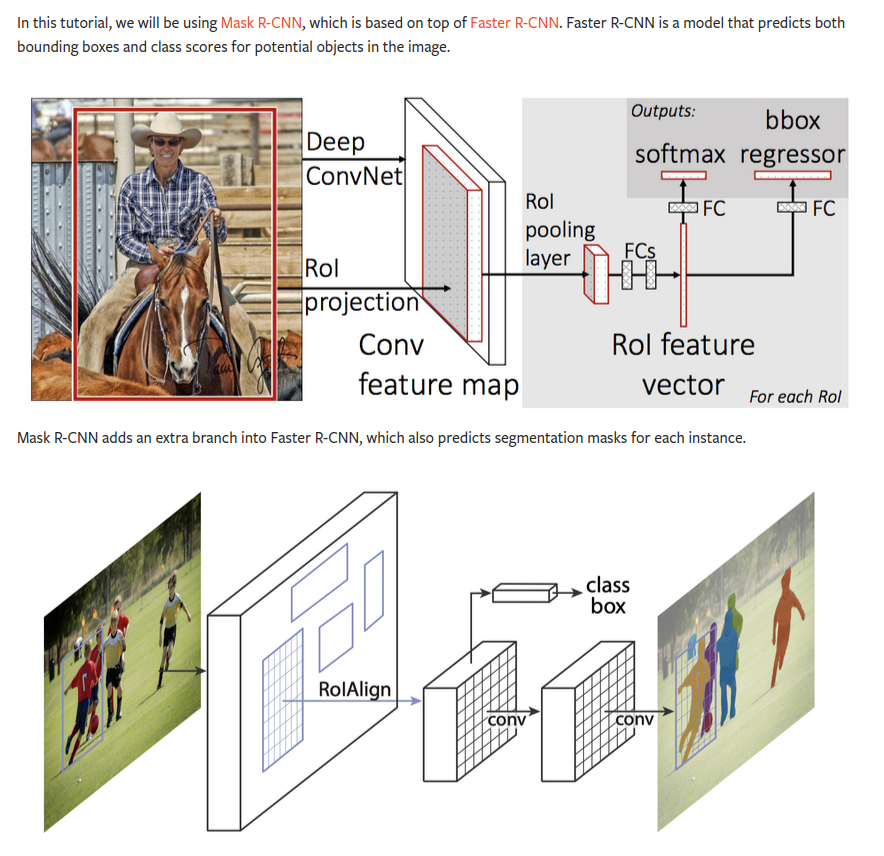

#### 1.Настройка предварительно обученной модели

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Загружаем модель, предобученную на COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# заменяем классификатор на новый, который имеет num_classes, определяемый пользователем
num_classes = 2 # 1 класс(человек) + фон
# получаем количество входящих фичей для классификации
in_features = model.roi_heads.box_predictor.cls_score.in_features
# заменяем обученый верхний слой на новый
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#### 2.Модификация модели с добавлением другого главного слоя

In [6]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# Загружаем предобученную модель для классификации и возвращаем только фичи
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FastRCNN`` нужно знать количество выходных каналов в backbone.
# Для mobilenet_v2 это 1280
backbone.out_channels = 1280

# Создадим RPN генератор 5 х 3 якоря на каждое пространственное местоположение
# с 5 различными размерами и 3 различными соотношениями сторон
# Мы имеем Tuple[Tuple[int]] потому что каждая особенность карты может иметь
# различные размеры и соотношения сторон
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# Определим какие карты признаков мы будем использовать для обрезки нужной нам области,
# а также размер обрезки после изменения масштаба
# Если backbone возвращает Tensor, featmap_names должен быть [0].
# В более общем случае backbone должен возвращать OrderedDict[Tensor],
# а в featmap_names вы можете выбрать какие карты характеристик использовать
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# соединяем все в Faster-RCNN модель
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100.0%


## Модель обнаружения объектов и сегментации экземпляров для набора данных PennFudan

#### Будем использовать 1 подход, так как наш набор довольно мал

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # загружаем модель сегментации, обученную на COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # получаем количество входящих фичей для классификатора
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # заменяем предобученный верхний слой новым
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # получаем количество входящих фичей для маски классификатора
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # заменяем предиктор масок на навый
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model